## Where do embeddings come from?
### Embedding MNIST images and NLP sentences into vectors.


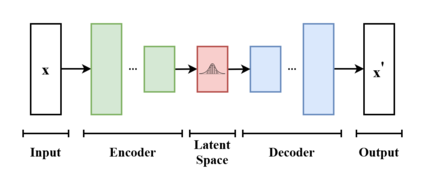

[Source](https://en.wikipedia.org/wiki/Variational_autoencoder)

In [13]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import ops
from keras.layers import Input, Dense, Layer
from matplotlib import pyplot as plt

In [14]:
import keras
print(keras.__version__)

3.3.2


In [15]:
class Sampling(Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)
    
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [16]:
# Load data – training and test
batch_size, n_epoch = 100, 50
n_hidden, latent_dim = 256, 2

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
x_train_flat = x_train.reshape((x_train.shape[0], -1))
x_test_flat = x_test.reshape((x_test.shape[0], -1))
mnist_digits = (
    np.concatenate([x_train_flat, x_test_flat], axis=0).astype("float32") / 255
)

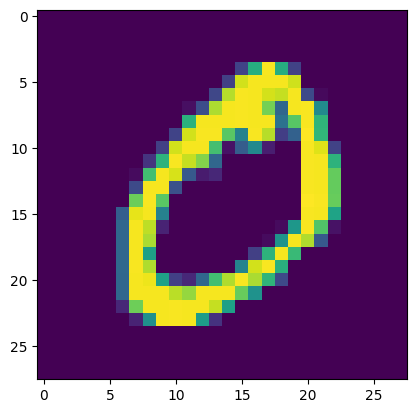

In [17]:
# Example of a training image
plt.imshow(x_train[1]);

In [18]:
# Encoder - from 784->256->128->2
encoder_inputs = keras.Input(shape=(28 * 28,))
x = Dense(n_hidden, activation="relu", name="h1")(
    encoder_inputs
)  # first hidden layer
x = Dense(n_hidden // 2, activation="relu", name="h2")(x)  # second hidden layer

# hidden state, which we will pass into the Model to get the Encoder.
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)
z = Sampling(name="z")([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 784)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ h1 (Dense)          │ (None, 256)       │    200,960 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ h2 (Dense)          │ (None, 128)       │     32,896 │ h1[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │        258 │ h2[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │        258 │ h2[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Sampling)        │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 234,372 (915.52 KB)

 Trainable params: 234,372 (915.52 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Decoder - from 2->128->256->784
latent_inputs = Input(shape=(latent_dim,))
x = Dense(n_hidden // 2, activation="relu")(latent_inputs)
x = Dense(n_hidden, activation="relu")(x)
decoder_outputs = Dense(28 * 28, activation="sigmoid")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 784)            │       201,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 234,896 (917.56 KB)

 Trainable params: 234,896 (917.56 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = ops.mean(
                ops.sum(keras.losses.binary_crossentropy(data, reconstruction))
            )
            kl_loss = -0.5 * (
                1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var)
            )
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [22]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128, verbose=2)
vae.save_weights("vae.weights.h5")

Epoch 1/30
547/547 - 8s - 15ms/step - kl_loss: 3.9341 - loss: 27.5832 - reconstruction_loss: 23.6491
Epoch 2/30
547/547 - 7s - 13ms/step - kl_loss: 3.9624 - loss: 27.5326 - reconstruction_loss: 23.5702
Epoch 3/30
547/547 - 7s - 13ms/step - kl_loss: 3.9690 - loss: 27.5074 - reconstruction_loss: 23.5384
Epoch 4/30
547/547 - 6s - 12ms/step - kl_loss: 3.9873 - loss: 27.5070 - reconstruction_loss: 23.5197
Epoch 5/30
547/547 - 6s - 11ms/step - kl_loss: 4.0013 - loss: 27.4579 - reconstruction_loss: 23.4566
Epoch 6/30
547/547 - 7s - 12ms/step - kl_loss: 4.0100 - loss: 27.4688 - reconstruction_loss: 23.4588
Epoch 7/30
547/547 - 7s - 12ms/step - kl_loss: 4.0260 - loss: 27.4468 - reconstruction_loss: 23.4207
Epoch 8/30
547/547 - 7s - 13ms/step - kl_loss: 4.0475 - loss: 27.4126 - reconstruction_loss: 23.3651
Epoch 9/30
547/547 - 7s - 12ms/step - kl_loss: 4.0477 - loss: 27.4077 - reconstruction_loss: 23.3600
Epoch 10/30
547/547 - 6s - 12ms/step - kl_loss: 4.0696 - loss: 27.4043 - reconstruction_los

### Visualize Embeddings

In [23]:
# Build encoders
vae = VAE(encoder, decoder)
vae.load_weights("vae.weights.h5")

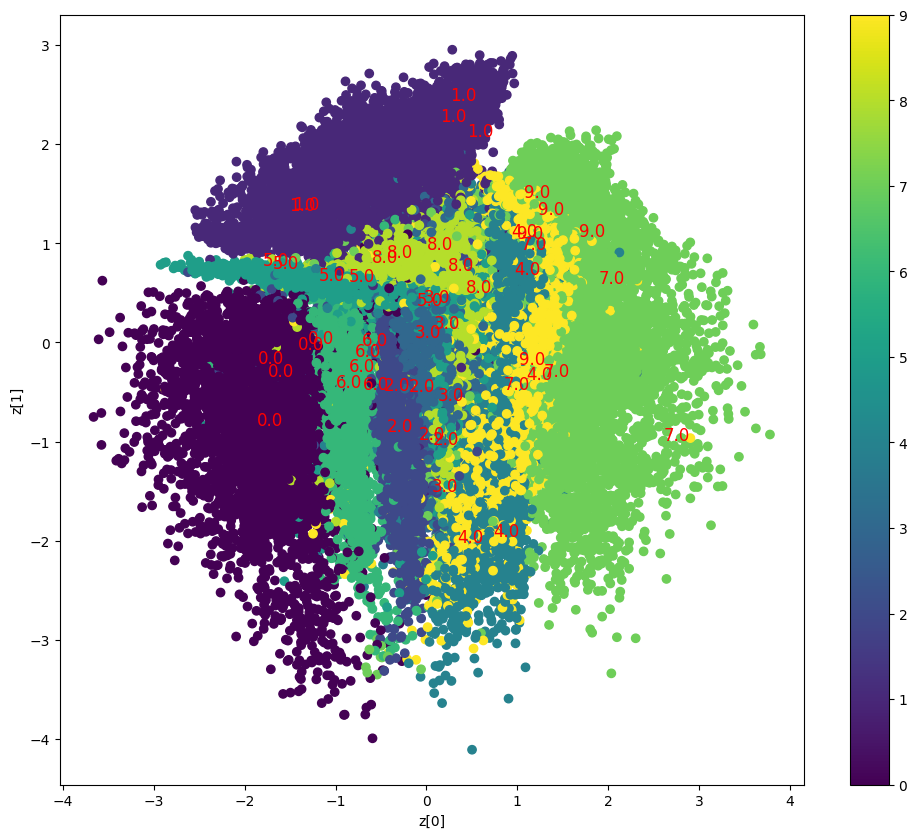

In [25]:
# Plot of the digit classes in the latent space
(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = x_train.reshape((x_train.shape[0], -1))
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
z_mean, z_log_var, z = vae.encoder.predict(x_train, verbose=0)
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_train)

df = pd.DataFrame(columns=["z[0]", "z[1]", "class"])
df["z[0]"] = z_mean[:, 0]
df["z[1]"] = z_mean[:, 1]
df["class"] = y_train

groups = df.groupby("class").head(5)
for i, row in groups.iterrows():
    plt.text(row["z[0]"], row["z[1]"], str(row["class"]), fontsize=12, color="red")

plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

## Example: compare three embeddings

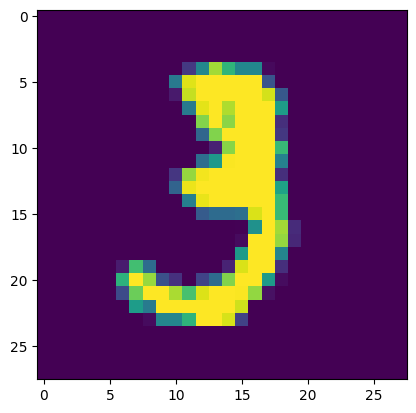

In [26]:
plt.imshow(x_train[10].reshape(28,28));

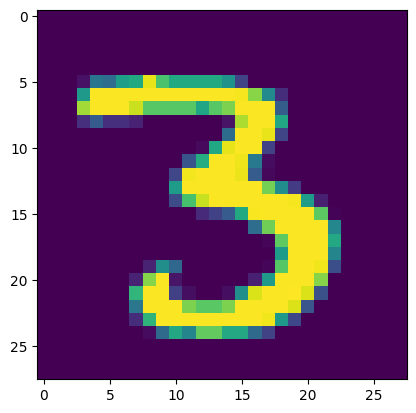

In [32]:
plt.imshow(x_train[12].reshape(28,28));

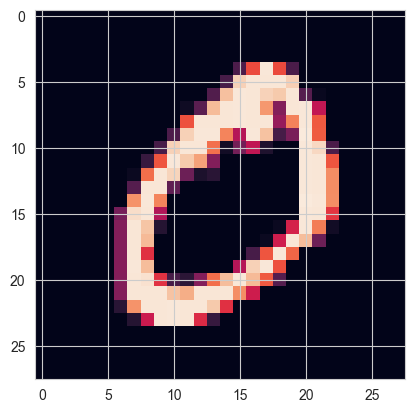

In [63]:
plt.imshow(x_train[1].reshape(28,28));

In [64]:
# calculate vectors for each digit
three_A = z_mean[10]
three_B = z_mean[12]
zero = z_mean[2]

print(f"Embedding for the first ThreeA is  {three_A}")
print(f"Embedding for the second ThreeB is {three_B}")
print(f"Embedding for the zero is         {zero}")

Embedding for the first ThreeA is  [-0.12608731  0.05614686]
Embedding for the second ThreeB is [ 0.12703623 -0.5825704 ]
Embedding for the zero is         [ 0.7385087 -1.9552722]


## Using more advanced models based on the Transformer architechture you can embed sentences aswell.

In [36]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [37]:
#Sentences we want to encode. Example:
sentence = ['The team enjoyed the hike through the meadow',
            'The national park had great views',
            'Olive oil drizzled over pizza tastes delicious']

In [38]:
#Sentences are encoded by calling model.encode()
embedding = model.encode(sentence)

#Preview the embeddings
print(embedding)

[[ 0.3706197   0.2641418   0.2126565  ...  0.14994514 -0.2579494
  -0.23970783]
 [ 0.66933304  0.40094942 -0.48208413 ...  0.10645875 -1.5067164
  -0.01547384]
 [-0.265559    0.11172336 -0.14733069 ...  0.421975    0.8839461
   0.1076391 ]]


In [39]:
embedding.shape

(3, 384)

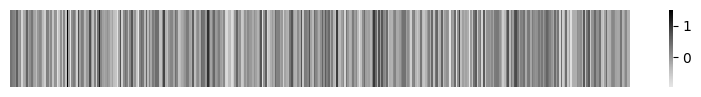

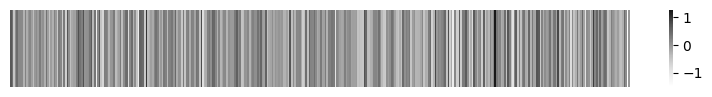

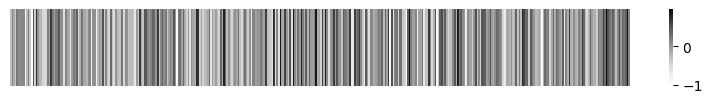

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(embedding[0].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

sns.heatmap(embedding[1].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

sns.heatmap(embedding[2].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

## How can we measure the distance between these Image and Sentence Embeddings?

There are many ways to calculate the distances between two vectors.

Here we will cover 4 distance metrics that you might find being used in the context of vector databases:
- Euclidean Distance(L2)
- Manhattan Distance(L1)
- Dot Product
- Cosine Distance

### Euclidean Distance(L2)
The length of the shortest path between two points or vectors.

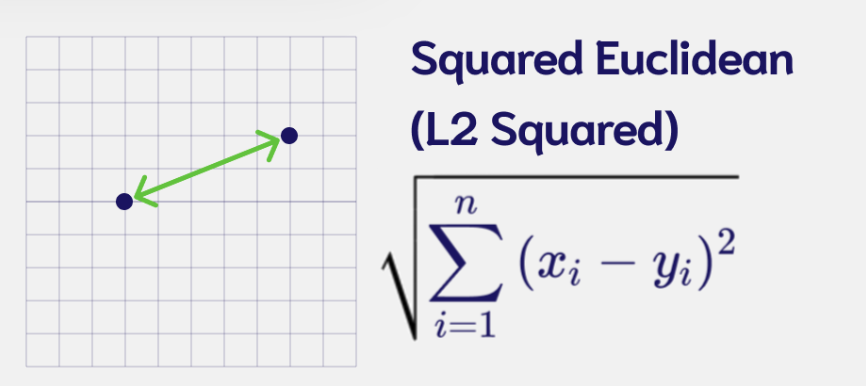

In [42]:
# Euclidean Distance
L2 = [(three_A[i] - three_B[i])**2 for i in range(len(three_A))]
L2 = np.sqrt(np.array(L2).sum())
print(L2)

0.6870452841491003


In [43]:
#An alternative way of doing this
np.linalg.norm((three_A - three_B), ord=2)

0.6870453

In [65]:
#Calculate L2 distances
print("Distance three_A-three_B:", np.linalg.norm((three_A - three_B), ord=2))
print("Distance three_A-zero:  ", np.linalg.norm((three_A - zero), ord=2))
print("Distance three_B-zero:  ", np.linalg.norm((three_B - zero), ord=2))

Distance three_A-three_B: 0.6870453
Distance three_A-zero:   2.189368
Distance three_B-zero:   1.5027338


### Manhattan Distance(L1)
Distance between two points if one was constrained to move only along one axis at a time.

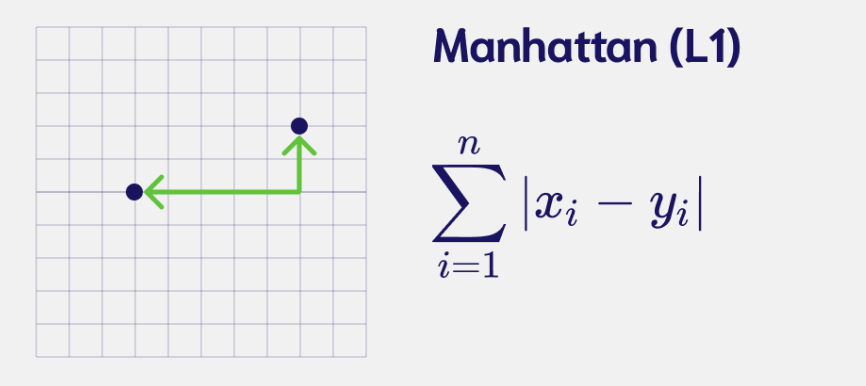

In [66]:
# Manhattan Distance
L1 = [three_A[i] - three_B[i] for i in range(len(three_A))]
L1 = np.abs(L1).sum()

print(L1)

0.89184076


In [46]:
#an alternative way of doing this is
np.linalg.norm((three_A - three_B), ord=1)

0.89184076

In [67]:
#Calculate L1 distances
print("Distance three_A-three_B:", np.linalg.norm((three_A - three_B), ord=1))
print("Distance three_A-zero:  ", np.linalg.norm((three_A - zero), ord=1))
print("Distance three_B-zero:  ", np.linalg.norm((three_B - zero), ord=1))

Distance three_A-three_B: 0.89184076
Distance three_A-zero:   2.8760152
Distance three_B-zero:   1.9841744


### Dot Product
Measures the magnitude of the projection of one vector onto the other.

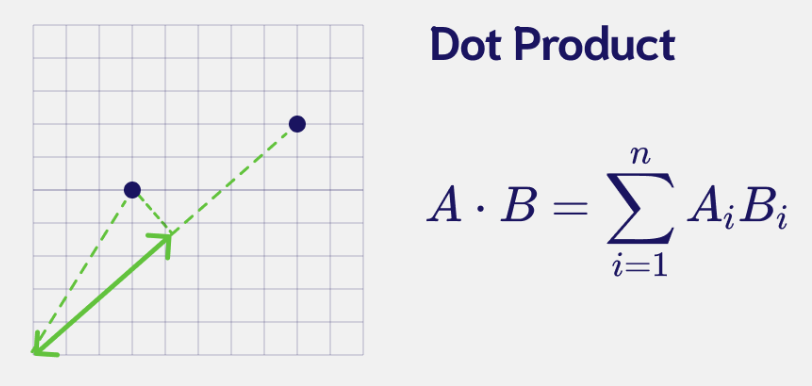

In [48]:
# Dot Product
np.dot(three_A,three_B)

-0.048727155

In [68]:
#Calculate Dot products
print("Distance three_A-three_B:", np.dot(three_A, three_B))
print("Distance three_A-zero:  ", np.dot(three_A, zero))
print("Distance three_B-zero:  ", np.dot(three_B, zero))

Distance three_A-three_B: -0.048727155
Distance three_A-zero:   -0.20289898
Distance three_B-zero:   1.232901


### Cosine Distance
Measure the difference in directionality between vectors.

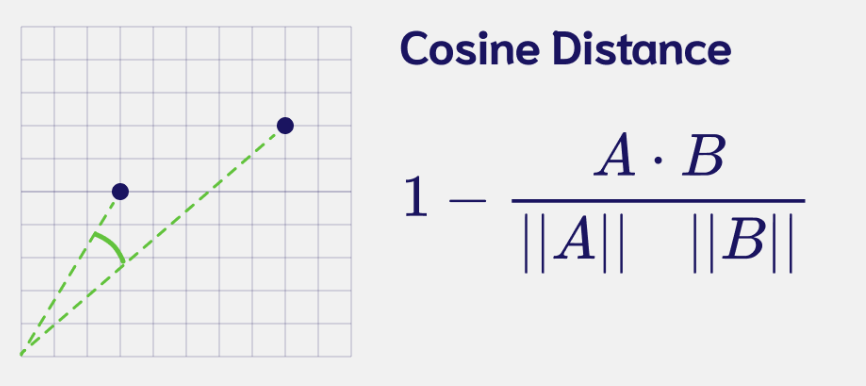

In [50]:
# Cosine Distance
cosine = 1 - np.dot(three_A,three_B)/(np.linalg.norm(three_A)*np.linalg.norm(three_B))
print(f"{cosine:.6f}")

1.592082


In [51]:
three_A/three_B

array([-0.9925303 , -0.09637781], dtype=float32)

In [53]:
# Cosine Distance function
def cosine_distance(vec1,vec2):
  cosine = 1 - (np.dot(vec1, vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2)))
  return cosine

In [69]:
#Cosine Distance
print(f"Distance three_A-three_B: {cosine_distance(three_A, three_B): .6f}")
print(f"Distance three_A-zero:   {cosine_distance(three_A, zero): .6f}")
print(f"Distance three_B-zero:   {cosine_distance(three_B, zero): .6f}")

Distance three_A-three_B:  1.592082
Distance three_A-zero:    1.703334
Distance three_B-zero:    0.010703


## Now with the sentence embeddings!

Dot Product and Cosine Distance are commonly used in the field of NLP, to evaluate how similar two sentence embeddings are.
So here we will only use those two.

- embedding0 - 'The team enjoyed the hike through the meadow'

- embedding1 - The national park had great views'

- embedding2 - 'Olive oil drizzled over pizza tastes delicious'

In [55]:
#Dot Product
print("Distance 0-1:", np.dot(embedding[0], embedding[1]))
print("Distance 0-2:", np.dot(embedding[0], embedding[2]))
print("Distance 1-2:", np.dot(embedding[1], embedding[2]))

Distance 0-1: 26.497894
Distance 0-2: 2.0785844
Distance 1-2: 4.0192156


In [56]:
#Cosine Distance
print("Distance 0-1: ", cosine_distance(embedding[0], embedding[1]))
print("Distance 0-2: ", cosine_distance(embedding[0], embedding[2]))
print("Distance 1-2: ", cosine_distance(embedding[1], embedding[2]))

Distance 0-1:  0.5350335538387299
Distance 0-2:  0.9639391973614693
Distance 1-2:  0.928879052400589
